In [1]:
from __future__ import print_function, division
import os
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17049649184888533539, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11683732911305749511
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8787105752243032917
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11064705024
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4453923316058252305
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import tarfile
fname = 'data.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [0]:
class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'distorted')
        self.y_path = os.path.join(data_dir, 'clean')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform
        self.train_data = []
        self.test_data = []
        self.labels_data = []

    def __len__(self):
        if self.train:
            return len(self.x_files_paths)
        else:
            return len(self.x_test_files_paths)

    def __getitem__(self, idx):
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            x = self.transform(x_image)
            y = self.transform(y_image)
            self.train_data.append(x)
            self.labels_data.append(y)
            return x,y
            
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            x = self.transform(x_test_image)
            self.test_data.append(x)
            return x
        
    def get_train_data(self, num):
        return torch.stack(self.train_data[:num]), torch.stack(self.labels_data[:num])
    def get_val_data(self, num):
        return torch.stack(self.val_data[:num]), torch.stack(self.val_labels_data[:num])
    
    def get_test_data(self, num):
        return torch.stack(self.test_data[:num])

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
      
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            
            nn.Conv2d(32, 16, (3, 3), padding=1),
            nn.ReLU(inplace=True),
 
            
        )
        self.out = nn.Sigmoid()

        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(16, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(32, 64, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(64, 3, (3, 3), padding=1),
        )

    def forward(self, x):
        residual = x
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded + residual
        decoded = self.out(decoded)
        
        return encoded, decoded


In [6]:
# Hyper Parameters
epochs = 16
lr = 0.005
n_plots = 1
batch_size = 32
torch.manual_seed(42)

torch.Size([32, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1529, 0.1529, 0.1529,  ..., 0.1725, 0.1725, 0.1725],
         [0.7529, 0.7529, 0.7529,  ..., 0.7725, 0.7725, 0.7725],
         ...,
         [0.8392, 0.7686, 0.6824,  ..., 0.7961, 0.7647, 0.7451],
         [0.6549, 0.6000, 0.5451,  ..., 0.5608, 0.5412, 0.5255],
         [0.1333, 0.0941, 0.0863,  ..., 0.1294, 0.1176, 0.1137]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1804, 0.1804, 0.1804,  ..., 0.2000, 0.2000, 0.2000],
         [0.7804, 0.7804, 0.7804,  ..., 0.8000, 0.8000, 0.8000],
         ...,
         [0.7451, 0.6745, 0.5882,  ..., 0.6941, 0.6627, 0.6431],
         [0.5608, 0.5059, 0.4510,  ..., 0.4549, 0.4353, 0.4196],
         [0.0353, 0.0000, 0.0000,  ..., 0.0196, 0.0078, 0.0039]],

        [[0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
         [0.2549, 0.2549, 0.2549,  ..., 0.2745, 0.2745, 0.2745],
         [0.8549, 0.8549, 0.85

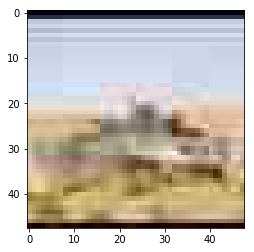

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.1765, 0.1765, 0.1765,  ..., 0.1804, 0.1804, 0.1804],
         [0.7216, 0.7255, 0.7255,  ..., 0.7412, 0.7412, 0.7412],
         ...,
         [0.8275, 0.7647, 0.6549,  ..., 0.8157, 0.7843, 0.7176],
         [0.6431, 0.6392, 0.5647,  ..., 0.6039, 0.5569, 0.4745],
         [0.0667, 0.0588, 0.0510,  ..., 0.0314, 0.0275, 0.0235]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.2039, 0.2039, 0.2039,  ..., 0.2039, 0.2039, 0.2039],
         [0.7843, 0.7882, 0.7882,  ..., 0.7843, 0.7843, 0.7843],
         ...,
         [0.6667, 0.6118, 0.5176,  ..., 0.6902, 0.6667, 0.6000],
         [0.5373, 0.5333, 0.4667,  ..., 0.5412, 0.4980, 0.4157],
         [0.0078, 0.0000, 0.0000,  ..., 0.0235, 0.0235, 0.0196]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2431, 0.2431, 0.2431,  ..., 0.2510, 0.2510, 0.2510],
         [0.8824, 0.8863, 0.8863,  ..., 0.8941, 0.8941, 0.

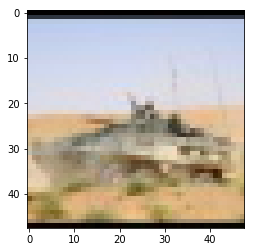

In [7]:
train_dataset = DenoisingDataset('data', 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(next(iter(train_loader))[0].shape)

def show_img(image):
    print(image)
    plt.imshow(image.permute(1, 2, 0).type(torch.FloatTensor)  )
    plt.pause(0.001)  # pause a bit so that plots are updated
    
show_img(train_dataset.get_train_data(5)[0][3])
show_img(train_dataset.get_train_data(5)[1][3])

0it [00:00, ?it/s]

Epoch:  0 | train loss: 0.0836
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


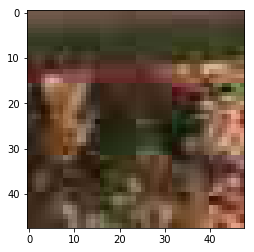

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

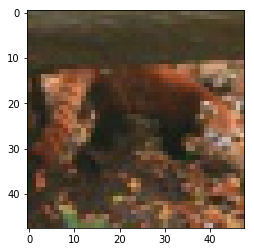

tensor([[[0.5901, 0.5850, 0.5835,  ..., 0.5775, 0.5829, 0.5955],
         [0.5788, 0.5737, 0.5760,  ..., 0.5804, 0.5827, 0.5930],
         [0.5934, 0.5828, 0.5806,  ..., 0.5746, 0.5801, 0.5946],
         ...,
         [0.5634, 0.5579, 0.5488,  ..., 0.6392, 0.6044, 0.6044],
         [0.5641, 0.5624, 0.5547,  ..., 0.6791, 0.6589, 0.6641],
         [0.5976, 0.5891, 0.6012,  ..., 0.7232, 0.7126, 0.6860]],

        [[0.6158, 0.6035, 0.5933,  ..., 0.5774, 0.5829, 0.5856],
         [0.5951, 0.5815, 0.5749,  ..., 0.5656, 0.5684, 0.5745],
         [0.6075, 0.5879, 0.5767,  ..., 0.5598, 0.5646, 0.5696],
         ...,
         [0.5732, 0.5627, 0.5511,  ..., 0.5941, 0.5549, 0.5488],
         [0.5668, 0.5617, 0.5534,  ..., 0.6340, 0.6162, 0.6178],
         [0.5730, 0.5549, 0.5653,  ..., 0.6575, 0.6539, 0.6346]],

        [[0.5307, 0.5210, 0.5159,  ..., 0.4962, 0.5003, 0.5140],
         [0.4948, 0.4759, 0.4751,  ..., 0.4716, 0.4752, 0.4988],
         [0.4960, 0.4677, 0.4606,  ..., 0.4517, 0.4603, 0.

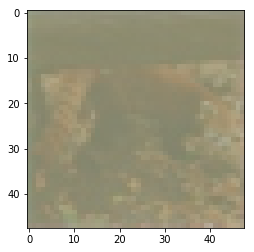

100it [01:27,  1.15it/s]

Epoch:  0 | train loss: 0.0042
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


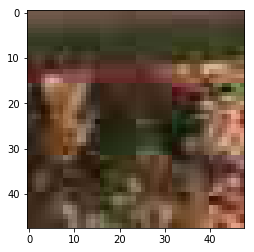

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

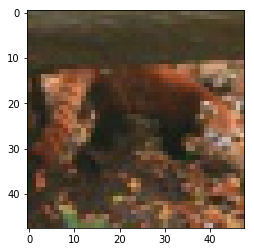

tensor([[[0.3866, 0.3678, 0.3755,  ..., 0.3410, 0.3423, 0.3824],
         [0.3443, 0.3779, 0.3936,  ..., 0.3582, 0.3144, 0.3365],
         [0.3784, 0.4068, 0.4265,  ..., 0.3586, 0.3213, 0.3038],
         ...,
         [0.2547, 0.2860, 0.3063,  ..., 0.6129, 0.5112, 0.4049],
         [0.2486, 0.2273, 0.2405,  ..., 0.6600, 0.5567, 0.4922],
         [0.3807, 0.2845, 0.2917,  ..., 0.6936, 0.6484, 0.5716]],

        [[0.4141, 0.3217, 0.3044,  ..., 0.2738, 0.2694, 0.3193],
         [0.3243, 0.2963, 0.3101,  ..., 0.2750, 0.2349, 0.2895],
         [0.3504, 0.3404, 0.3300,  ..., 0.2618, 0.2381, 0.2496],
         ...,
         [0.2310, 0.1971, 0.1880,  ..., 0.4608, 0.3724, 0.3322],
         [0.2325, 0.1806, 0.1569,  ..., 0.5298, 0.4423, 0.4208],
         [0.2331, 0.2152, 0.2007,  ..., 0.5584, 0.5263, 0.5200]],

        [[0.3190, 0.2580, 0.2359,  ..., 0.2088, 0.1819, 0.2813],
         [0.2305, 0.1866, 0.2040,  ..., 0.1668, 0.1331, 0.2290],
         [0.2448, 0.1869, 0.1796,  ..., 0.1320, 0.1046, 0.

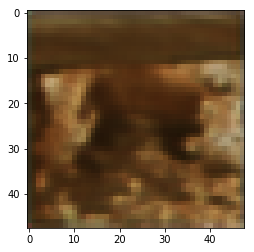

200it [02:55,  1.14it/s]

Epoch:  0 | train loss: 0.0032
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


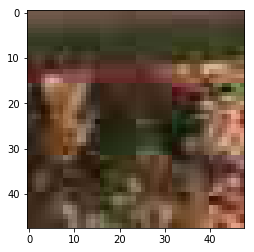

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

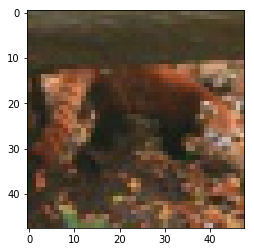

tensor([[[0.3866, 0.3618, 0.3738,  ..., 0.3366, 0.3528, 0.3821],
         [0.3267, 0.3458, 0.3693,  ..., 0.3457, 0.3306, 0.3198],
         [0.3478, 0.3623, 0.3769,  ..., 0.3273, 0.3158, 0.2772],
         ...,
         [0.2269, 0.2616, 0.2592,  ..., 0.6342, 0.5011, 0.3875],
         [0.2041, 0.2074, 0.2061,  ..., 0.7114, 0.5766, 0.5046],
         [0.3119, 0.2250, 0.2083,  ..., 0.6945, 0.6391, 0.5769]],

        [[0.4190, 0.3461, 0.3419,  ..., 0.2989, 0.3087, 0.3472],
         [0.3311, 0.3078, 0.3422,  ..., 0.3007, 0.2805, 0.2946],
         [0.3400, 0.3428, 0.3471,  ..., 0.2881, 0.2827, 0.2656],
         ...,
         [0.2257, 0.2324, 0.2244,  ..., 0.4830, 0.3472, 0.3227],
         [0.2104, 0.1977, 0.1980,  ..., 0.5749, 0.4658, 0.4300],
         [0.2536, 0.2120, 0.2066,  ..., 0.5594, 0.5372, 0.5245]],

        [[0.3206, 0.2974, 0.2729,  ..., 0.2380, 0.2241, 0.2917],
         [0.2444, 0.2308, 0.2490,  ..., 0.2179, 0.1917, 0.2296],
         [0.2494, 0.2384, 0.2299,  ..., 0.1888, 0.1717, 0.

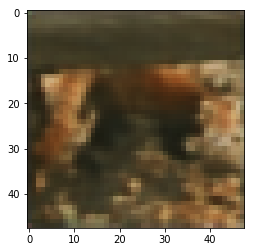

300it [04:22,  1.15it/s]

Epoch:  0 | train loss: 0.0035
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


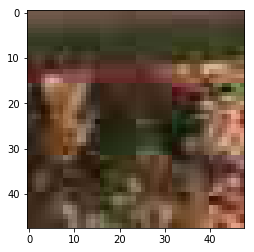

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

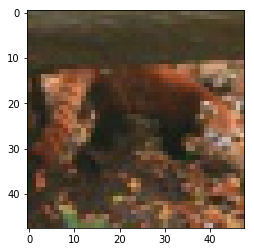

tensor([[[0.4070, 0.3816, 0.3889,  ..., 0.3599, 0.3755, 0.4043],
         [0.3575, 0.3656, 0.3864,  ..., 0.3688, 0.3585, 0.3491],
         [0.3704, 0.3824, 0.3936,  ..., 0.3475, 0.3382, 0.3014],
         ...,
         [0.2342, 0.2788, 0.2764,  ..., 0.6576, 0.5064, 0.4039],
         [0.2237, 0.2418, 0.2458,  ..., 0.7614, 0.6304, 0.5320],
         [0.3174, 0.2373, 0.2248,  ..., 0.7322, 0.6857, 0.5986]],

        [[0.4210, 0.3555, 0.3452,  ..., 0.3058, 0.3163, 0.3591],
         [0.3485, 0.3200, 0.3350,  ..., 0.2957, 0.2871, 0.2946],
         [0.3481, 0.3382, 0.3371,  ..., 0.2774, 0.2765, 0.2608],
         ...,
         [0.2151, 0.2356, 0.2158,  ..., 0.4727, 0.3269, 0.3152],
         [0.2110, 0.2152, 0.2046,  ..., 0.6023, 0.4946, 0.4351],
         [0.2607, 0.2149, 0.2069,  ..., 0.5894, 0.5641, 0.5355]],

        [[0.3269, 0.3053, 0.2754,  ..., 0.2369, 0.2360, 0.2995],
         [0.2561, 0.2368, 0.2429,  ..., 0.2087, 0.1990, 0.2254],
         [0.2568, 0.2418, 0.2335,  ..., 0.1884, 0.1865, 0.

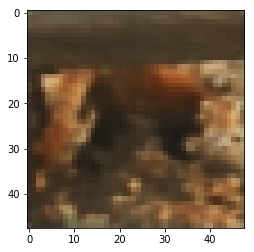

313it [04:34,  1.35it/s]
0it [00:00, ?it/s]

Epoch:  1 | train loss: 0.0031
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


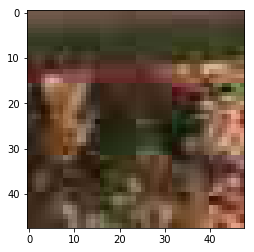

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

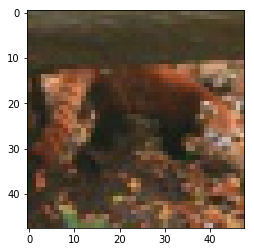

tensor([[[0.3730, 0.3498, 0.3603,  ..., 0.3267, 0.3451, 0.3878],
         [0.3241, 0.3347, 0.3601,  ..., 0.3389, 0.3324, 0.3365],
         [0.3398, 0.3516, 0.3599,  ..., 0.3113, 0.3076, 0.2905],
         ...,
         [0.2096, 0.2489, 0.2438,  ..., 0.6221, 0.4926, 0.3934],
         [0.1973, 0.2128, 0.2142,  ..., 0.7252, 0.5957, 0.5195],
         [0.2898, 0.2133, 0.2041,  ..., 0.6815, 0.6398, 0.5753]],

        [[0.3987, 0.3400, 0.3325,  ..., 0.2938, 0.3077, 0.3544],
         [0.3192, 0.3042, 0.3221,  ..., 0.2851, 0.2785, 0.2896],
         [0.3231, 0.3304, 0.3211,  ..., 0.2642, 0.2671, 0.2593],
         ...,
         [0.2002, 0.2299, 0.2074,  ..., 0.4518, 0.3241, 0.3101],
         [0.1964, 0.2099, 0.1959,  ..., 0.5836, 0.4731, 0.4296],
         [0.2428, 0.2054, 0.1993,  ..., 0.5474, 0.5236, 0.5185]],

        [[0.3128, 0.2992, 0.2750,  ..., 0.2382, 0.2365, 0.3037],
         [0.2447, 0.2403, 0.2522,  ..., 0.2224, 0.2119, 0.2376],
         [0.2461, 0.2475, 0.2372,  ..., 0.1944, 0.1934, 0.

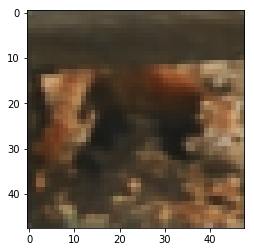

100it [01:27,  1.15it/s]

Epoch:  1 | train loss: 0.0036
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


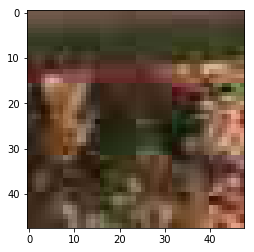

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

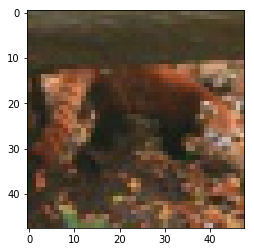

tensor([[[0.3900, 0.3603, 0.3660,  ..., 0.3315, 0.3532, 0.3923],
         [0.3484, 0.3380, 0.3598,  ..., 0.3364, 0.3336, 0.3276],
         [0.3620, 0.3537, 0.3628,  ..., 0.3114, 0.3115, 0.2841],
         ...,
         [0.2253, 0.2360, 0.2372,  ..., 0.6377, 0.4989, 0.4035],
         [0.2126, 0.2063, 0.2112,  ..., 0.7507, 0.6013, 0.5160],
         [0.3027, 0.2208, 0.2184,  ..., 0.7164, 0.6697, 0.5816]],

        [[0.4188, 0.3675, 0.3622,  ..., 0.3215, 0.3363, 0.3746],
         [0.3627, 0.3385, 0.3568,  ..., 0.3220, 0.3166, 0.3020],
         [0.3634, 0.3529, 0.3569,  ..., 0.2976, 0.3022, 0.2693],
         ...,
         [0.2262, 0.2488, 0.2379,  ..., 0.4624, 0.3275, 0.3233],
         [0.2157, 0.2208, 0.2141,  ..., 0.6043, 0.4816, 0.4270],
         [0.2668, 0.2220, 0.2236,  ..., 0.5887, 0.5581, 0.5247]],

        [[0.3206, 0.3018, 0.2843,  ..., 0.2387, 0.2430, 0.3039],
         [0.2603, 0.2415, 0.2576,  ..., 0.2200, 0.2128, 0.2254],
         [0.2614, 0.2460, 0.2482,  ..., 0.2011, 0.2030, 0.

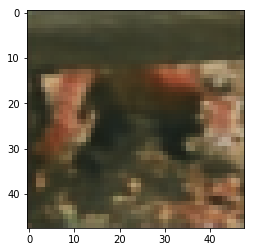

200it [02:55,  1.16it/s]

Epoch:  1 | train loss: 0.0034
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


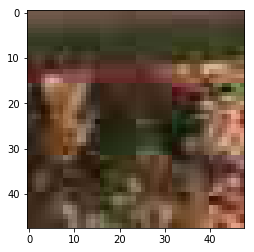

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

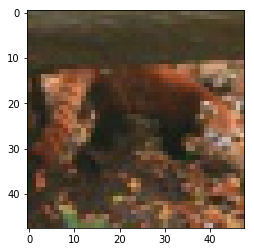

tensor([[[0.3944, 0.3817, 0.3880,  ..., 0.3476, 0.3715, 0.4046],
         [0.3509, 0.3582, 0.3753,  ..., 0.3532, 0.3593, 0.3404],
         [0.3630, 0.3690, 0.3726,  ..., 0.3202, 0.3258, 0.2851],
         ...,
         [0.2314, 0.2404, 0.2465,  ..., 0.6639, 0.5254, 0.4451],
         [0.2213, 0.2224, 0.2263,  ..., 0.7576, 0.6144, 0.5352],
         [0.3000, 0.2288, 0.2262,  ..., 0.7316, 0.6861, 0.5973]],

        [[0.4212, 0.3902, 0.3810,  ..., 0.3433, 0.3550, 0.3844],
         [0.3610, 0.3655, 0.3713,  ..., 0.3393, 0.3442, 0.3109],
         [0.3560, 0.3563, 0.3566,  ..., 0.2986, 0.3062, 0.2685],
         ...,
         [0.2262, 0.2394, 0.2367,  ..., 0.4935, 0.3709, 0.3487],
         [0.2191, 0.2287, 0.2214,  ..., 0.5970, 0.4867, 0.4345],
         [0.2605, 0.2177, 0.2229,  ..., 0.5901, 0.5784, 0.5277]],

        [[0.3051, 0.2929, 0.2723,  ..., 0.2200, 0.2279, 0.2913],
         [0.2351, 0.2340, 0.2389,  ..., 0.1931, 0.2035, 0.2132],
         [0.2423, 0.2359, 0.2291,  ..., 0.1758, 0.1848, 0.

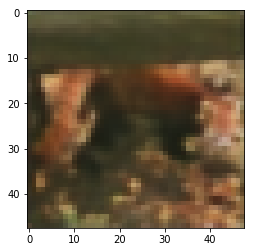

300it [04:23,  1.13it/s]

Epoch:  1 | train loss: 0.0029
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


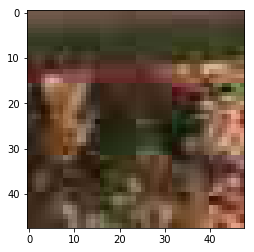

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

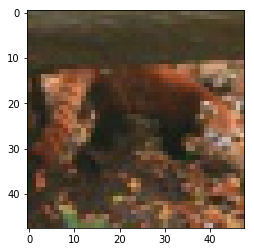

tensor([[[0.3723, 0.3559, 0.3580,  ..., 0.3158, 0.3344, 0.3807],
         [0.3250, 0.3211, 0.3463,  ..., 0.3180, 0.3174, 0.3125],
         [0.3364, 0.3320, 0.3448,  ..., 0.2954, 0.2940, 0.2679],
         ...,
         [0.2157, 0.2217, 0.2270,  ..., 0.5968, 0.4572, 0.3971],
         [0.2011, 0.2080, 0.2119,  ..., 0.7197, 0.5580, 0.5124],
         [0.2756, 0.2126, 0.2088,  ..., 0.7004, 0.6591, 0.5830]],

        [[0.3899, 0.3568, 0.3484,  ..., 0.3013, 0.3127, 0.3561],
         [0.3324, 0.3162, 0.3305,  ..., 0.2932, 0.2959, 0.2782],
         [0.3277, 0.3133, 0.3203,  ..., 0.2635, 0.2658, 0.2442],
         ...,
         [0.2063, 0.2051, 0.2041,  ..., 0.4349, 0.3069, 0.3045],
         [0.1942, 0.1874, 0.1868,  ..., 0.5695, 0.4392, 0.3965],
         [0.2470, 0.1910, 0.1992,  ..., 0.5709, 0.5516, 0.5048]],

        [[0.2889, 0.2710, 0.2552,  ..., 0.2038, 0.2070, 0.2724],
         [0.2215, 0.2122, 0.2236,  ..., 0.1824, 0.1864, 0.1960],
         [0.2278, 0.2123, 0.2131,  ..., 0.1638, 0.1694, 0.

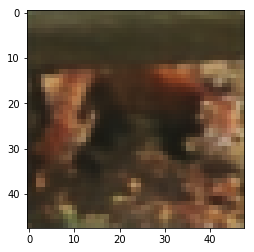

313it [04:35,  1.33it/s]
0it [00:00, ?it/s]

Epoch:  2 | train loss: 0.0026
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


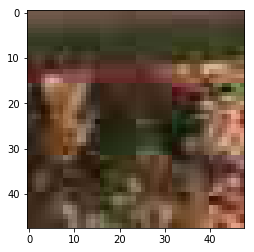

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

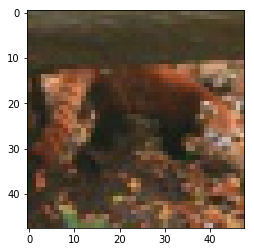

tensor([[[0.3763, 0.3638, 0.3638,  ..., 0.3247, 0.3423, 0.3817],
         [0.3253, 0.3250, 0.3463,  ..., 0.3222, 0.3229, 0.3136],
         [0.3351, 0.3342, 0.3431,  ..., 0.2942, 0.2944, 0.2673],
         ...,
         [0.2127, 0.2170, 0.2183,  ..., 0.6195, 0.4774, 0.4086],
         [0.1988, 0.2025, 0.2004,  ..., 0.7329, 0.5775, 0.5228],
         [0.2747, 0.2112, 0.2039,  ..., 0.7081, 0.6713, 0.5866]],

        [[0.3984, 0.3722, 0.3649,  ..., 0.3222, 0.3317, 0.3674],
         [0.3393, 0.3328, 0.3482,  ..., 0.3166, 0.3177, 0.2937],
         [0.3348, 0.3335, 0.3404,  ..., 0.2870, 0.2879, 0.2612],
         ...,
         [0.2157, 0.2262, 0.2264,  ..., 0.4692, 0.3320, 0.3201],
         [0.2063, 0.2056, 0.2055,  ..., 0.5976, 0.4718, 0.4149],
         [0.2565, 0.2043, 0.2126,  ..., 0.5882, 0.5748, 0.5133]],

        [[0.2982, 0.2890, 0.2750,  ..., 0.2253, 0.2267, 0.2855],
         [0.2307, 0.2306, 0.2449,  ..., 0.2051, 0.2063, 0.2107],
         [0.2368, 0.2354, 0.2381,  ..., 0.1872, 0.1908, 0.

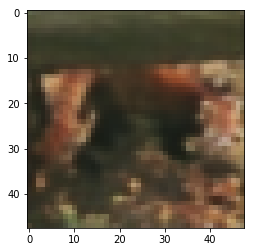

100it [01:28,  1.15it/s]

Epoch:  2 | train loss: 0.0025
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2824, 0.2824,  ..., 0.2431, 0.2392, 0.2353],


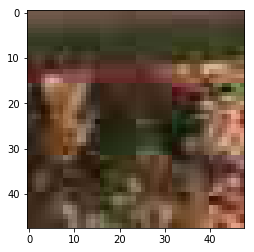

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

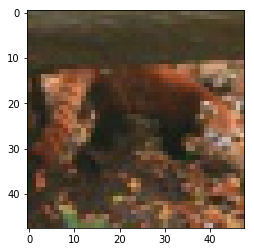

tensor([[[0.3831, 0.3757, 0.3773,  ..., 0.3371, 0.3469, 0.3853],
         [0.3356, 0.3318, 0.3559,  ..., 0.3302, 0.3256, 0.3136],
         [0.3521, 0.3430, 0.3542,  ..., 0.3070, 0.3024, 0.2736],
         ...,
         [0.2272, 0.2290, 0.2307,  ..., 0.6234, 0.4772, 0.4023],
         [0.2086, 0.2168, 0.2126,  ..., 0.7338, 0.5781, 0.5197],
         [0.2847, 0.2269, 0.2194,  ..., 0.7148, 0.6838, 0.5932]],

        [[0.4033, 0.3804, 0.3726,  ..., 0.3277, 0.3340, 0.3705],
         [0.3455, 0.3348, 0.3489,  ..., 0.3146, 0.3123, 0.2934],
         [0.3454, 0.3358, 0.3440,  ..., 0.2877, 0.2855, 0.2633],
         ...,
         [0.2214, 0.2227, 0.2261,  ..., 0.4729, 0.3331, 0.3154],
         [0.2077, 0.1986, 0.2024,  ..., 0.5890, 0.4608, 0.4064],
         [0.2580, 0.2016, 0.2145,  ..., 0.5848, 0.5786, 0.5137]],

        [[0.2994, 0.2926, 0.2786,  ..., 0.2265, 0.2259, 0.2829],
         [0.2269, 0.2252, 0.2378,  ..., 0.1970, 0.1983, 0.2051],
         [0.2366, 0.2267, 0.2289,  ..., 0.1769, 0.1810, 0.

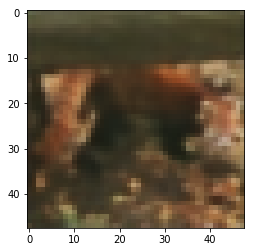

171it [02:31,  1.14it/s]

In [0]:
in_data, original_data = train_dataset.get_train_data(n_plots)
autoencoder = ConvAutoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6,9], gamma=0.1)

for epoch in range(epochs):
    autoencoder.train()
    for step, (x, y) in tqdm.tqdm(enumerate(train_loader)):

        encoded, decoded = autoencoder(x) 
        loss = loss_func(decoded, y)
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 100 == 0:# and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())
            _, decoded_data = autoencoder(original_data)
            print(in_data.shape)
            show_img(in_data.squeeze(0))
            show_img(original_data.squeeze(0))
            show_img(decoded_data.data.squeeze(0))
          
    scheduler.step()

In [0]:
test_dataset = DenoisingDataset('data', 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                ]))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
decoded_samples = []
autoencoder.eval()
for step, x in enumerate(test_loader): 
    _,de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    
sampled_z = np.concatenate(decoded_samples, axis=0)


def save_result(images: np.ndarray, out_path: str):
    assert images.shape == (400, 3, 48, 48)
    flat_img = images.reshape(400, -1)
    n_rows = np.prod(images.shape)
    
    y_with_id = np.concatenate([np.arange(n_rows).reshape(-1, 1), flat_img.reshape(n_rows, 1)], axis=1)
    np.savetxt(out_path, y_with_id, delimiter=",", fmt=['%d', '%.4f'], header="id,expetced", comments='')
    
save_result(sampled_z, 'solution.csv')
show_img(x[0].squeeze(0))
show_img(de_x[0].data.squeeze(0))
